In [318]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from tqdm.auto import tqdm

plt.style.use('ggplot')

In [319]:
df = pd.read_csv('cookie_cats.csv')

In [320]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [322]:
df["retention_1"] = df["retention_1"].astype(int)
df["retention_7"] = df["retention_7"].astype(int)

In [323]:
df["retention_1_and_7"] = np.where((df.retention_1 == 1) & (df.retention_7 == 1), 1,0)

In [357]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7,retention_1_and_7
0,116,gate_30,3,0,0,0
1,337,gate_30,38,1,0,0
2,377,gate_40,165,1,0,0
3,483,gate_40,1,0,0,0
4,488,gate_40,179,1,1,1


Text(0.5, 1.0, 'The number of users in the first 100 game rounds played')

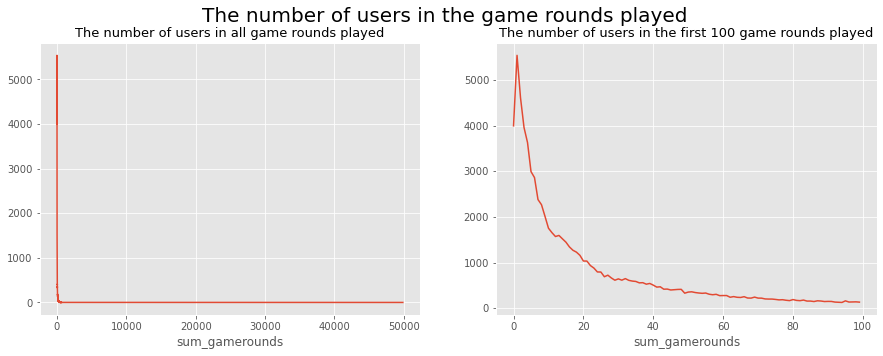

In [325]:
fig, axes = plt.subplots(1, 2, figsize = (15,5))
count_of_users = df.groupby('sum_gamerounds')['userid'].count()
count_of_users.plot(ax = axes[0])
count_of_users[:100].plot(ax = axes[1])
plt.suptitle("The number of users in the game rounds played", fontsize = 20)
axes[0].set_title("The number of users in all game rounds played", fontsize = 13)
axes[1].set_title("The number of users in the first 100 game rounds played", fontsize = 13)

In [326]:
df.groupby('sum_gamerounds', as_index=False).agg({'userid':'count'})

,sum_gamerounds,userid
0,0,3994
1,1,5538
2,2,4606
3,3,3958
4,4,3629
...,...,...
937,2294,1
938,2438,1
939,2640,1
940,2961,1


In [327]:
df.groupby('version').agg({'sum_gamerounds': ['count', 'mean', 'median', 'std', 'min', 'max']})

sum_gamerounds                                         
                 count       mean median         std min    max
version                                                        
gate_30          44700  52.456264   17.0  256.716423   0  49854
gate_40          45489  51.298776   16.0  103.294416   0   2640

In [328]:
gate_30 = df.loc[df['version']=='gate_30']

In [329]:
gate_40 = df.loc[df['version']=='gate_40']

Text(0.5, 1.0, 'Distribution of Two Groups')

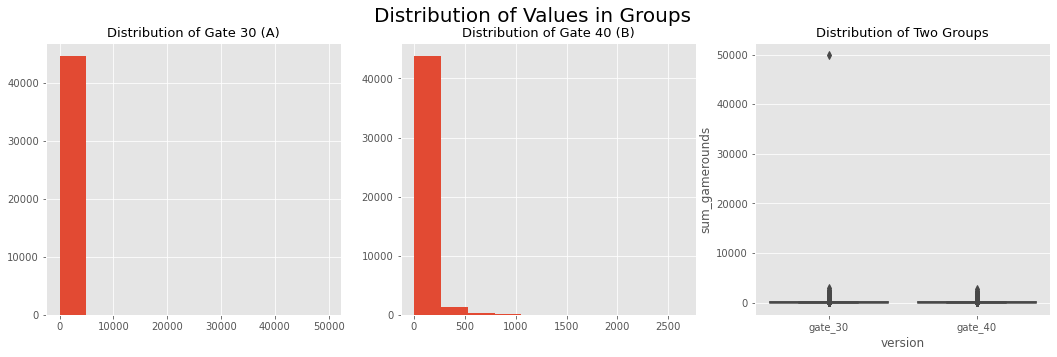

In [330]:
fig, axes = plt.subplots(1, 3, figsize = (18,5))
gate_30['sum_gamerounds'].hist(ax = axes[0])
gate_40['sum_gamerounds'].hist(ax = axes[1])
sns.boxplot(x = df.version, y = df.sum_gamerounds, ax = axes[2])
plt.suptitle("Distribution of Values in Groups", fontsize = 20)
axes[0].set_title("Distribution of Gate 30 (A)", fontsize = 13)
axes[1].set_title("Distribution of Gate 40 (B)", fontsize = 13)
axes[2].set_title("Distribution of Two Groups", fontsize = 13)

In [331]:
df['sum_gamerounds'].quantile(q=[0.99])

0.99    493.0
Name: sum_gamerounds, dtype: float64

In [332]:
df_without_extreme_values = df.loc[df['sum_gamerounds'] < 493]

Text(0.5, 1.0, 'Distribution of Two Groups')

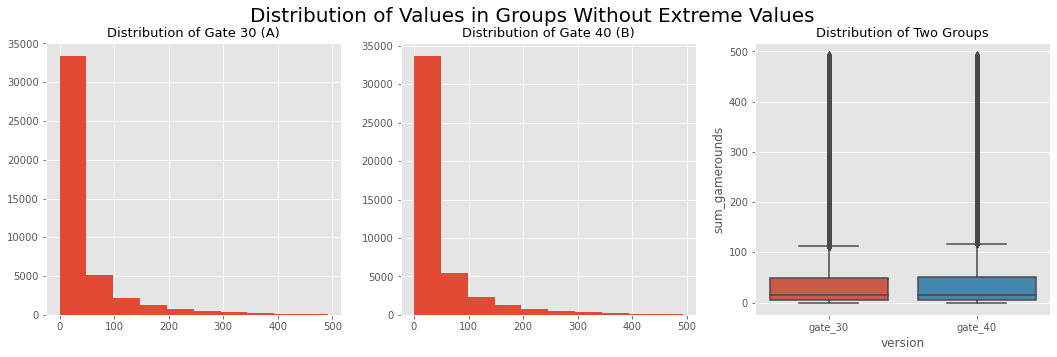

In [333]:
fig, axes = plt.subplots(1, 3, figsize = (18,5))
df_without_extreme_values.loc[df_without_extreme_values['version']=='gate_30']['sum_gamerounds'].hist(ax = axes[0])
df_without_extreme_values.loc[df_without_extreme_values['version']=='gate_40']['sum_gamerounds'].hist(ax = axes[1])
sns.boxplot(x = df_without_extreme_values.version, y = df_without_extreme_values.sum_gamerounds, ax = axes[2])
plt.suptitle("Distribution of Values in Groups Without Extreme Values", fontsize = 20)
axes[0].set_title("Distribution of Gate 30 (A)", fontsize = 13)
axes[1].set_title("Distribution of Gate 40 (B)", fontsize = 13)
axes[2].set_title("Distribution of Two Groups", fontsize = 13)

In [334]:
gate_30_sample = gate_30['sum_gamerounds'].sample(1000, random_state=17)
stats.shapiro(gate_30_sample)

ShapiroResult(statistic=0.5699042081832886, pvalue=4.484155085839415e-44)

In [335]:
gate_40_sample = gate_40['sum_gamerounds'].sample(1000, random_state=17)
stats.shapiro(gate_40_sample)

ShapiroResult(statistic=0.5420246124267578, pvalue=5.605193857299268e-45)

In [336]:
stats.mannwhitneyu(gate_30['sum_gamerounds'], gate_40['sum_gamerounds'])

MannwhitneyuResult(statistic=1024331250.5, pvalue=0.05020880772044255)

In [337]:
def get_bootstrap_mean(
    data_column_1,
    data_column_2,
    boot_it = 1000,
    statistic = np.mean,
    bootstrap_conf_level = 0.95
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)):
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2))
        
    pd_boot_data = pd.DataFrame(boot_data)
    
    boot = [np.mean(boot_data)]
    
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = stats.norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = stats.norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2

    
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data,
            "ci": ci, 
            "boot": {np.mean(boot_data)},
            "p_value": p_value}

  0%|          | 0/1000 [00:00<?, ?it/s]

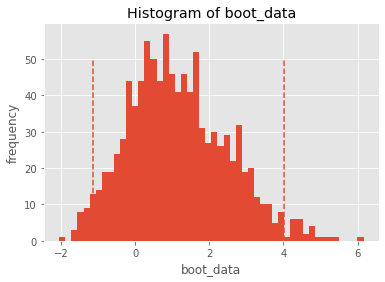

In [338]:
gamerounds_bootstrap = get_bootstrap_mean(gate_30['sum_gamerounds'], gate_40['sum_gamerounds'])

In [339]:
gamerounds_bootstrap['p_value']

0.38824101874631123

In [340]:
gamerounds_bootstrap['ci']

,0
0.025,-1.152882
0.975,4.022960


In [341]:
first_day_retention = df['retention_1'].sum() / df['retention_1'].count()
first_day_retention

0.4452095044850259

In [342]:
seventh_day_retention = df['retention_7'].sum() / df['retention_7'].count()
seventh_day_retention

0.1860648194347426

In [344]:
retention = df.groupby('version', as_index=False).agg({'retention_1': lambda x: x.sum()/x.count(),
                                                        'retention_7': lambda x: x.sum()/x.count(),
                                                        'retention_1_and_7': lambda x: x.sum()/x.count()}) \
                                                   .rename(columns={'retention_1':'ratio_1', 'retention_7':'ratio_7', 
                                                                    'retention_1_and_7':'ratio_1_and_7'})
retention

,version,ratio_1,ratio_7,ratio_1_and_7
0,gate_30,0.448188,0.190201,0.149351
1,gate_40,0.442283,0.182000,0.143024


Text(0.5, 1.0, 'Retention on the First and Seventh day')

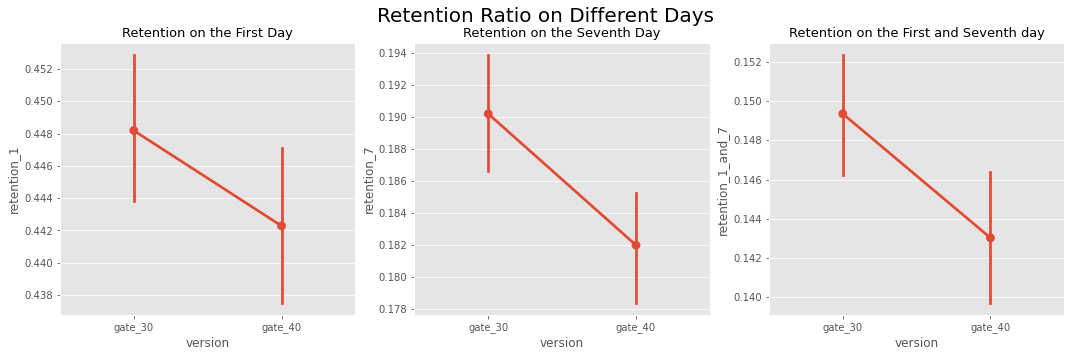

In [364]:
fig, axes = plt.subplots(1, 3, figsize = (18,5))
sns.pointplot(data=df, x='version', y='retention_1', ax = axes[0])
sns.pointplot(data=df, x='version', y='retention_7', ax = axes[1])
sns.pointplot(data=df, x='version', y='retention_1_and_7', ax = axes[2])
plt.suptitle("Retention Ratio on Different Days", fontsize = 20)
axes[0].set_title("Retention on the First Day", fontsize = 13)
axes[1].set_title("Retention on the Seventh Day", fontsize = 13)
axes[2].set_title("Retention on the First and Seventh day", fontsize = 13)

In [345]:
stats.mannwhitneyu(gate_30['retention_1'], gate_40['retention_1'])

MannwhitneyuResult(statistic=1022682813.0, pvalue=0.07441128639919536)

  0%|          | 0/1000 [00:00<?, ?it/s]

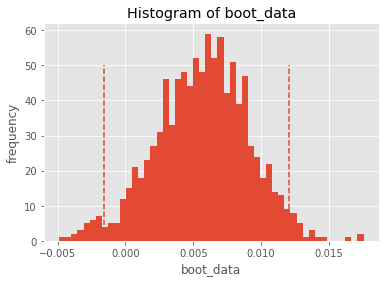

In [346]:
retention_1_bootstrap = get_bootstrap_mean(gate_30['retention_1'], gate_40['retention_1'])

In [347]:
retention_1_bootstrap['p_value']

0.09395180170320028

In [348]:
retention_1_bootstrap['ci']

,0
0.025,-0.001590
0.975,0.012025


In [349]:
stats.mannwhitneyu(gate_30['retention_7'], gate_40['retention_7'])

MannwhitneyuResult(statistic=1025017239.0, pvalue=0.001554344685704005)

  0%|          | 0/1000 [00:00<?, ?it/s]

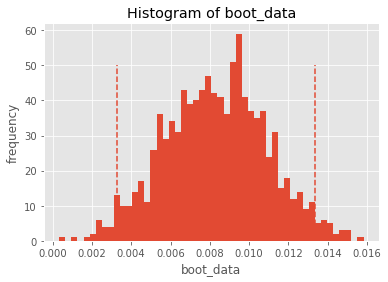

In [350]:
retention_7_bootstrap = get_bootstrap_mean(gate_30['retention_7'], gate_40['retention_7'])

In [351]:
retention_7_bootstrap['p_value']

0.0012236343948506896

In [352]:
retention_7_bootstrap['ci']

,0
0.025,0.003298
0.975,0.013346


In [353]:
stats.mannwhitneyu(gate_30['retention_1_and_7'], gate_40['retention_1_and_7'])

MannwhitneyuResult(statistic=1023112332.0, pvalue=0.0071564568248493575)

  0%|          | 0/1000 [00:00<?, ?it/s]

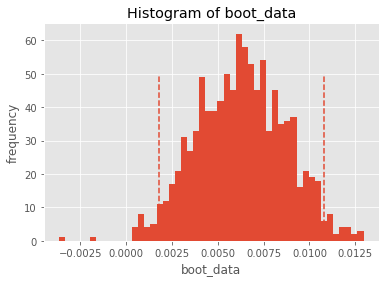

In [354]:
retention_1_and_7_bootstrap = get_bootstrap_mean(gate_30['retention_1_and_7'], gate_40['retention_1_and_7'])

In [355]:
retention_1_and_7_bootstrap['p_value']

0.008955862854397782

In [356]:
retention_1_and_7_bootstrap['ci']

,0
0.025,0.001780
0.975,0.010794
